
 ## Load packages


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc


In [2]:
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)


We are provided with an **anonymized dataset containing numeric feature variables**, the binary **target** column, and a string **ID_code** column.

The task is to predict the value of **target column** in the test set.


## Exploratory Data Analysis(EDA)


In [3]:
# import Dataset to play with it
train= pd.read_csv("../input/train.csv")
test = pd.read_csv('../input/test.csv')

In [4]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [5]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [6]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.195700000000000,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.637500000000000,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


## Reducing  memory size by 

1. 300 MB before Reducing
1. 150 MB after Reducing

In [7]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

Reducing for train data set

In [8]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276611328125  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

Reducing for test data set

In [9]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017822265625  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

In [10]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


 <a id="422"></a> <br>
## 4-2-2 numerical values Describe

In [11]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


 
## Visualization

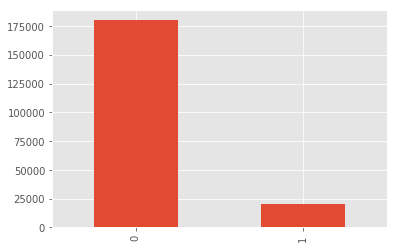

In [12]:
train['target'].value_counts().plot.bar();

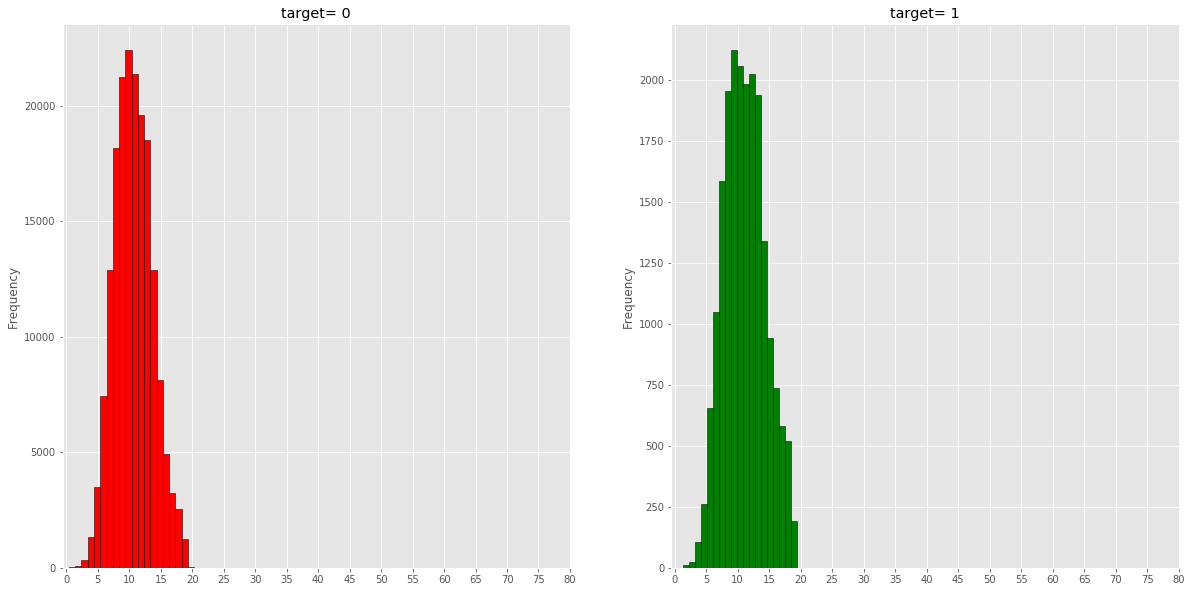

In [13]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

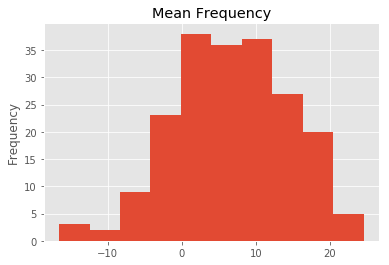

In [14]:
train[train.columns[2:]].mean().plot('hist');plt.title('Mean Frequency');

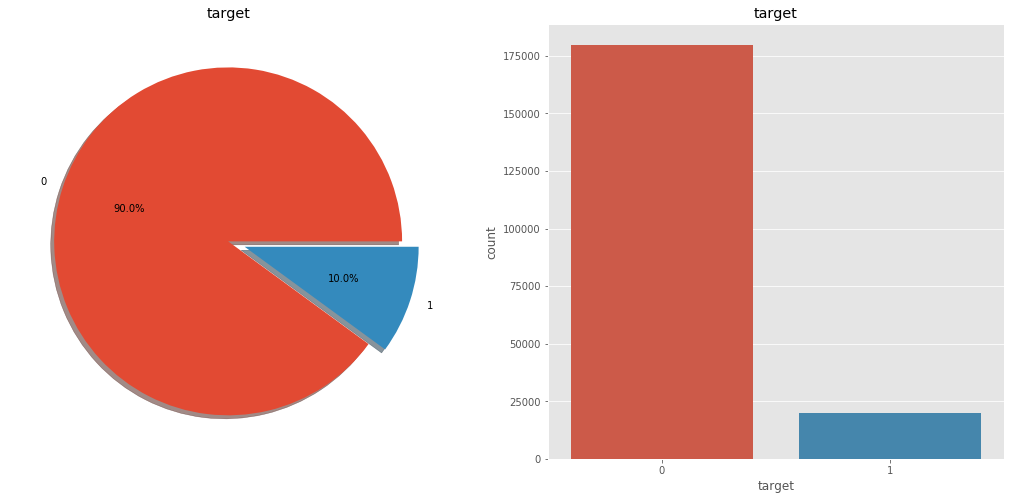

In [15]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('target')
plt.show()

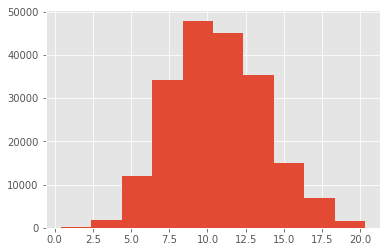

In [16]:
train["var_0"].hist();

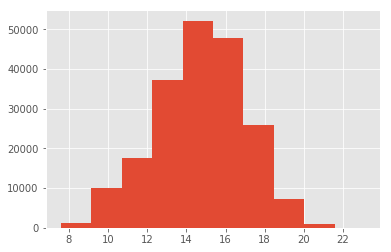

In [17]:
train["var_81"].hist();

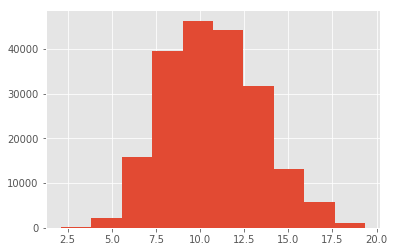

In [18]:
train["var_2"].hist();

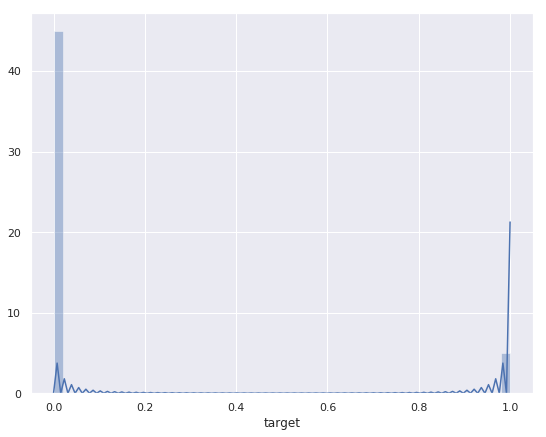

In [19]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

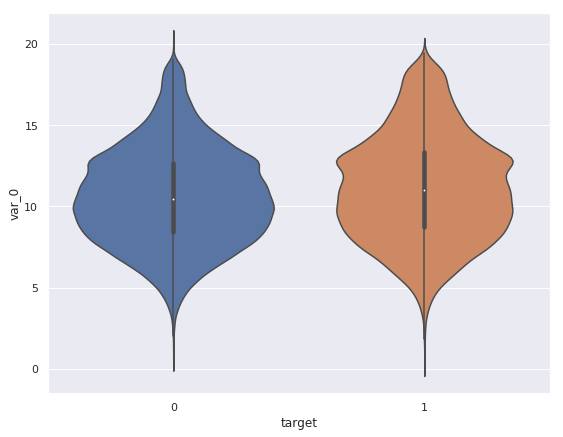

In [20]:
sns.violinplot(data=train,x="target", y="var_0")

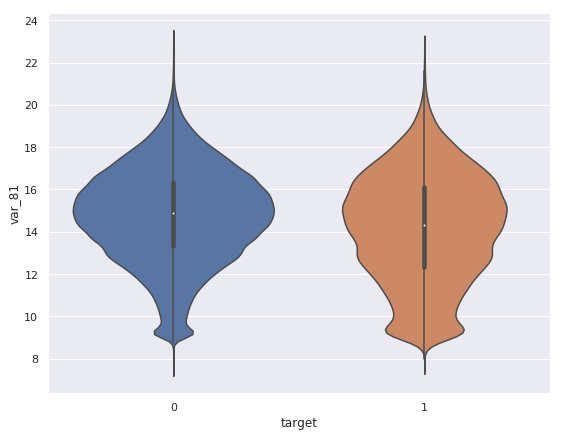

In [21]:
sns.violinplot(data=train,x="target", y="var_81")


## Check missing data for test & train

In [22]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [23]:
check_missing_data(train)

False

In [24]:
check_missing_data(test)

False

In [25]:
train['target'].unique()

array([0, 1], dtype=uint64)

In [26]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [27]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')
    

In [28]:
check_balance(train,'target')

size of data is: 200000
for target  0 =
89.95100000000001 %
for target  1 =
10.049 %


### Prepare our data for our model

In [29]:
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]


In [30]:
X_test  = test.drop("ID_code",axis=1)

### Feature importance

In [31]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [32]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

Using TensorFlow backend.


In [33]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


In [34]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [35]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [36]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

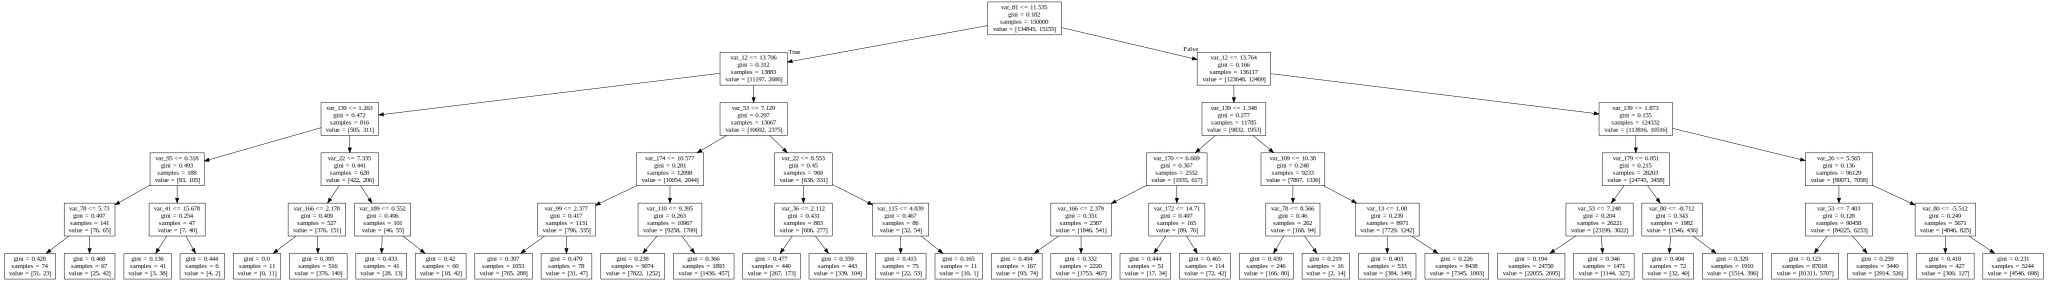

In [37]:
graphviz.Source(tree_graph)

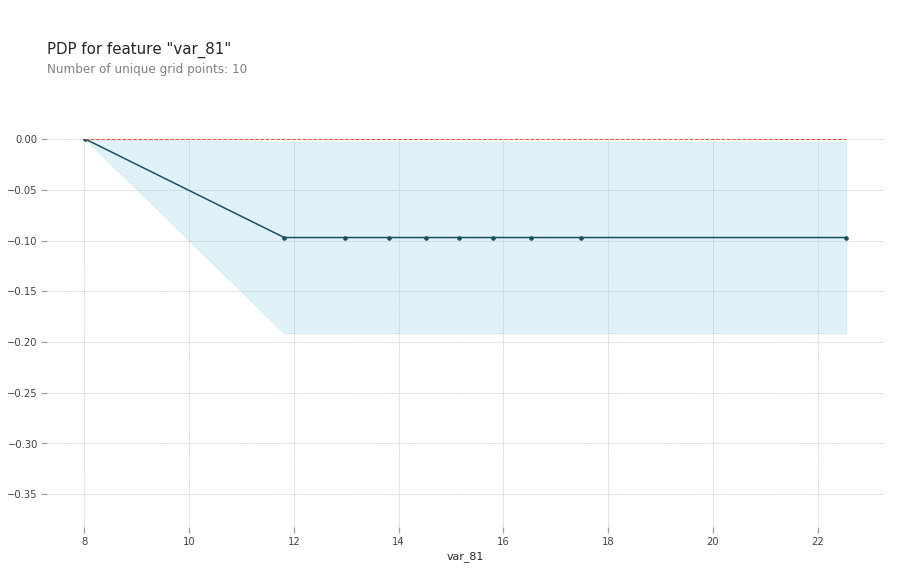

In [38]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

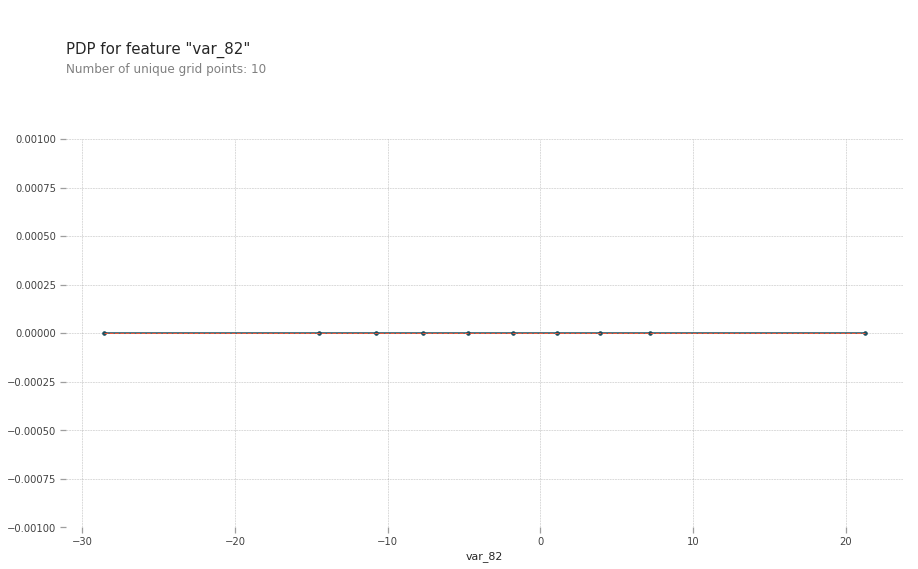

In [39]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

# plot it
pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

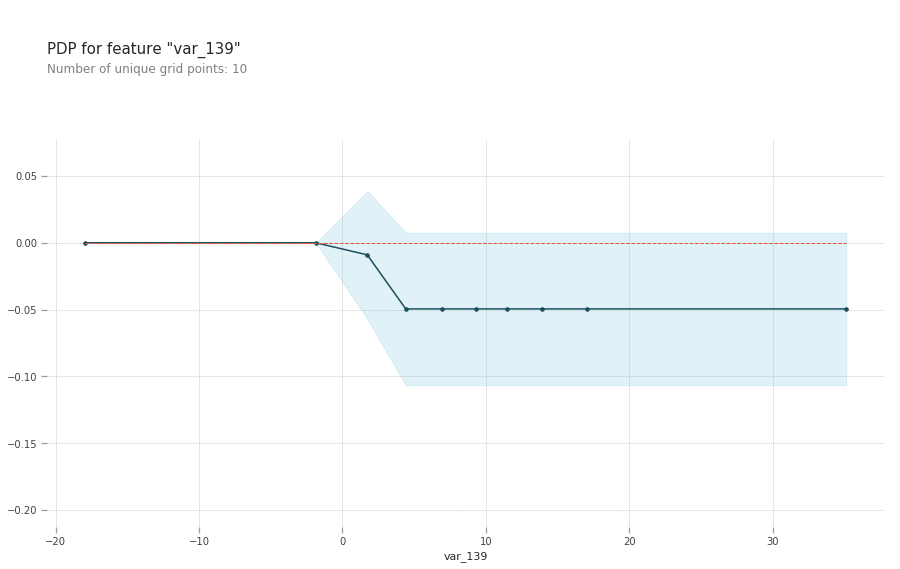

In [40]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

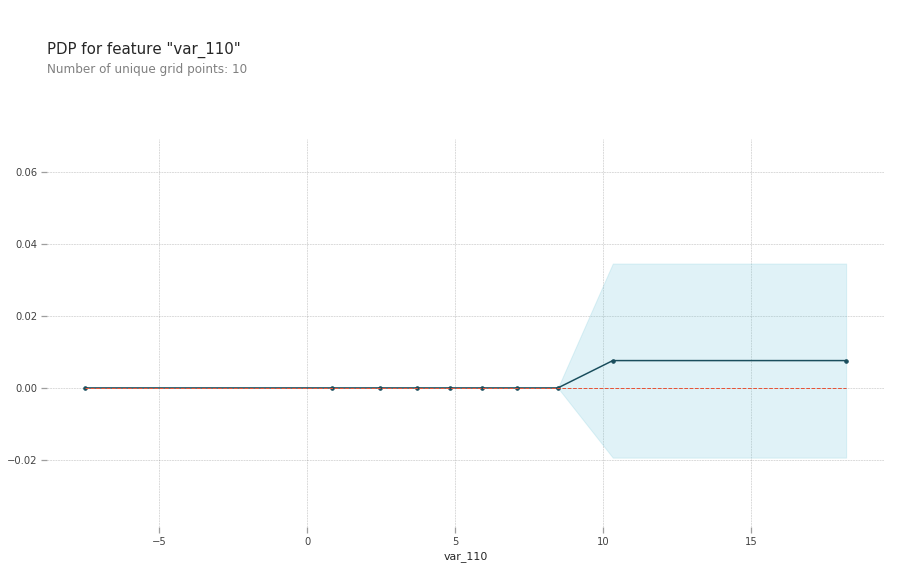

In [41]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

In [42]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


rfc_model.predict_proba(data_for_prediction_array);

In [43]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

##  lightgbm

In [45]:
# params is based on following kernel https://www.kaggle.com/brandenkmurray/nothing-works
params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [46]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Mon Sep  9 11:55:31 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.900588	valid_1's auc: 0.880449
[2000]	training's auc: 0.913223	valid_1's auc: 0.889714
[3000]	training's auc: 0.921448	valid_1's auc: 0.894046
[4000]	training's auc: 0.927561	valid_1's auc: 0.896388
[5000]	training's auc: 0.93274	valid_1's auc: 0.897752
[6000]	training's auc: 0.937336	valid_1's auc: 0.898587
[7000]	training's auc: 0.941554	valid_1's auc: 0.898994
[8000]	training's auc: 0.945477	valid_1's auc: 0.899054
[9000]	training's auc: 0.949124	valid_1's auc: 0.899097
[10000]	training's auc: 0.952659	valid_1's auc: 0.899148
[11000]	training's auc: 0.95605	valid_1's auc: 0.89926
[12000]	training's auc: 0.959214	valid_1's auc: 0.899213
[13000]	training's auc: 0.962302	valid_1's auc: 0.899098
[14000]	training's auc: 0.965193	valid_1's auc: 0.899074
Early stopping, best iteration is:
[11233]	training's auc: 0.956795	valid_1's auc: 0.89929
Fold 1 started a


## RandomForestClassifier

In [47]:
y_pred_rfc = rfc_model.predict(X_test)


##  DecisionTreeClassifier

In [48]:
y_pred_tree = tree_model.predict(X_test)


## CatBoostClassifier

In [49]:
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(train_X,train_y,silent=True)
y_pred_cat = cat_model.predict(X_test)

## Submissions

In [50]:
submission_rfc = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_rfc
    })
submission_rfc.to_csv('submission_rfc.csv', index=False)

In [51]:
submission_tree = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_tree
    })
submission_tree.to_csv('submission_tree.csv', index=False)

In [52]:
submission_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_cat
    })
submission_cat.to_csv('submission_cat.csv', index=False)

In [53]:
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)